# Comprehensive Comparative Analysis of Multimodal Medical Image Fusion Methods

This notebook combines exact codes from all test notebooks to provide a comprehensive comparison of multimodal medical image fusion methods. It includes:

**Deep Learning Methods:**
- DDCGAN Fusion
- ResNet Attention Fine-tuning Medical Model
- ResNet-based Fusion
- Trainable Wavelet Fusion

**Traditional Methods:**
- DWT-PCA Fusion
- Traditional Wavelet Fusion

**Features:**
- Automatic batch processing with 5 random image pairs
- Comprehensive evaluation metrics (SSIM, PSNR, Entropy, etc.)
- Statistical analysis across multiple test cases
- Automatic result visualization and reporting

In [1]:
# ===============================
# IMPORT REQUIRED LIBRARIES
# ===============================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import glob
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.decomposition import PCA
import pywt
from pytorch_wavelets import DWTForward, DWTInverse
import random
import time
import pandas as pd
from typing import Tuple, Dict, Any
import sys
import nibabel as nib
from skimage import exposure, filters
import json
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')

warnings.filterwarnings('ignore')

Using device: cuda
PyTorch version: 2.5.1


In [2]:
# ===============================
# MODEL DEFINITIONS AND LOADING
# ===============================

# 1. DDCGAN Model Components (from DDCGAN_fusion_test.ipynb)
class Block(nn.Module):
    def __init__(self, in_channels, filter_size, strides, kernel=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, filter_size, kernel, strides, kernel//2),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=2, out_channels=48, constant_feature_map=48):
        super().__init__()
        self.model = nn.Sequential(
            Block(in_channels, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, out_channels, 1)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, out_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, encoder_constant_features=48):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_constant_features, encoder_constant_features)
        self.decoder = Decoder(encoder_constant_features, out_channels)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [3]:
# 2. ResNet Attention Fine-tuning Medical Model (from resnet_attention_finetuning_medical_model_test.ipynb)
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.conv(x)
        attention = self.sigmoid(attention)
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DualAttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention(channels)

        self.fusion_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, vis_feat, ir_feat):
        vis_att = self.spatial_attention(self.channel_attention(vis_feat))
        ir_att = self.spatial_attention(self.channel_attention(ir_feat))

        combined = torch.cat([vis_att, ir_att], dim=1)
        fused = self.fusion_conv(combined)

        return fused

class MedicalFusionModel(nn.Module):
    """Adapted model for medical CT-MRI fusion"""
    def __init__(self):
        super().__init__()

        # Same architecture as ImprovedFusionModel but with medical adaptations
        backbone = models.resnet34(pretrained=True)

        # CT encoder (was visible encoder)
        self.ct_stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.ct_layer1 = backbone.layer1
        self.ct_layer2 = backbone.layer2
        self.ct_layer3 = backbone.layer3
        self.ct_layer4 = backbone.layer4

        # MRI encoder (was IR encoder)
        mri_backbone = models.resnet34(pretrained=True)
        old_conv1 = mri_backbone.conv1
        mri_backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            mri_backbone.conv1.weight = nn.Parameter(old_conv1.weight.mean(dim=1, keepdim=True))

        self.mri_stem = nn.Sequential(
            mri_backbone.conv1,
            mri_backbone.bn1,
            mri_backbone.relu,
            mri_backbone.maxpool
        )
        self.mri_layer1 = mri_backbone.layer1
        self.mri_layer2 = mri_backbone.layer2
        self.mri_layer3 = mri_backbone.layer3
        self.mri_layer4 = mri_backbone.layer4

        # Fusion blocks
        self.fusion1 = DualAttentionFusion(64)
        self.fusion2 = DualAttentionFusion(128)
        self.fusion3 = DualAttentionFusion(256)
        self.fusion4 = DualAttentionFusion(512)

        # Decoder with medical-specific modifications
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Final layer for medical fusion
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()  # Output in [0,1] for medical images
        )

        # Medical-specific attention layer
        self.medical_attention = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()
        )

    def forward(self, ct, mri):
        # Encode CT (3-channel)
        c0 = self.ct_stem(ct)
        c1 = self.ct_layer1(c0)
        c2 = self.ct_layer2(c1)
        c3 = self.ct_layer3(c2)
        c4 = self.ct_layer4(c3)

        # Encode MRI (1-channel)
        m0 = self.mri_stem(mri)
        m1 = self.mri_layer1(m0)
        m2 = self.mri_layer2(m1)
        m3 = self.mri_layer3(m2)
        m4 = self.mri_layer4(m3)

        # Fuse at each level
        f1 = self.fusion1(c1, m1)
        f2 = self.fusion2(c2, m2)
        f3 = self.fusion3(c3, m3)
        f4 = self.fusion4(c4, m4)

        # Decode
        d4 = self.decoder4(f4)
        d3 = self.decoder3(torch.cat([d4, f3], dim=1))
        d2 = self.decoder2(torch.cat([d3, f2], dim=1))
        d1 = self.decoder1(torch.cat([d2, f1], dim=1))

        output = self.final(d1)

        # Apply medical attention
        attention = self.medical_attention(output)
        output = output * attention

        return output

In [4]:
# 3. ResNet-based Fusion Model (from resnet_fusion_test.ipynb)
class ResNetFusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.fusion1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.fusion2 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fusion3 = nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def extract_features(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        return f1, f2, f3

    def forward(self, ct, mr):
        ct_f1, ct_f2, ct_f3 = self.extract_features(ct)
        mr_f1, mr_f2, mr_f3 = self.extract_features(mr)
        fused_f1 = self.fusion1(torch.cat([ct_f1, mr_f1], dim=1))
        fused_f2 = self.fusion2(torch.cat([ct_f2, mr_f2], dim=1))
        fused_f3 = self.fusion3(torch.cat([ct_f3, mr_f3], dim=1))
        x = self.up3(fused_f3)
        x = torch.cat([x, fused_f2], dim=1)
        x = self.up2(x)
        x = torch.cat([x, fused_f1], dim=1)
        x = self.up1(x)
        x = self.final(x)
        return x

In [5]:
# 4. Trainable Wavelet Fusion Model (from wavelet_fusion_test.ipynb)
class WaveletFusionNetSpatial(nn.Module):
    def __init__(self, wave='haar'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)
        self.idwt = DWTInverse(wave=wave)
        self.mask_net = nn.Sequential(
            nn.Conv2d(2,16,3,padding=1), nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,4,3,padding=1), nn.Sigmoid()
        )

    def forward(self, ct, mr):
        # --- Ensure 4D ---
        if ct.dim() == 3: ct = ct.unsqueeze(0)
        if mr.dim() == 3: mr = mr.unsqueeze(0)

        # --- DWT decomposition ---
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)

        # --- Split high-frequency channels ---
        # ct_high[0] has shape [batch, channels, 3, H, W] - need to properly index
        ct_lh, ct_hl, ct_hh = ct_high[0][:,:,0:1,:,:], ct_high[0][:,:,1:2,:,:], ct_high[0][:,:,2:3,:,:]
        mr_lh, mr_hl, mr_hh = mr_high[0][:,:,0:1,:,:], mr_high[0][:,:,1:2,:,:], mr_high[0][:,:,2:3,:,:]

        # Squeeze the extra dimension to get [batch, channels, H, W]
        ct_lh, ct_hl, ct_hh = ct_lh.squeeze(2), ct_hl.squeeze(2), ct_hh.squeeze(2)
        mr_lh, mr_hl, mr_hh = mr_lh.squeeze(2), mr_hl.squeeze(2), mr_hh.squeeze(2)

        # --- Low-frequency mask input ---
        low_stack = torch.cat([ct_low, mr_low], dim=1)
        # Keep mask computation at low-frequency resolution
        masks_low = self.mask_net(low_stack)
        mL, mLH_small, mHL_small, mHH_small = masks_low[:,0:1], masks_low[:,1:2], masks_low[:,2:3], masks_low[:,3:4]

        # Resize high-frequency masks to match high-frequency component dimensions
        high_freq_size = (ct_lh.shape[2], ct_lh.shape[3])
        mLH = F.interpolate(mLH_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHL = F.interpolate(mHL_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHH = F.interpolate(mHH_small, size=high_freq_size, mode='bilinear', align_corners=False)

        # --- Fuse low-frequency ---
        # Keep the low frequency at its original size (half of input size) for inverse DWT
        fused_low = mL*ct_low + (1-mL)*mr_low

        # --- Fuse high-frequency ---
        fused_lh = mLH*ct_lh + (1-mLH)*mr_lh
        fused_hl = mHL*ct_hl + (1-mHL)*mr_hl
        fused_hh = mHH*ct_hh + (1-mHH)*mr_hh

        # Stack them back to the original format for inverse DWT
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)  # (B,C,3,h,w)

        # --- Inverse DWT ---
        fused = self.idwt((fused_low, [fused_high]))
        return fused

In [ ]:
# Dataset classes from test notebooks
class CTMRIDataset(Dataset):
    """Dataset for CT-MRI fusion from DDCGAN test notebook"""
    def __init__(self, root_dir, transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        # Find all image pairs
        self.image_pairs = []

        print(f"Scanning dataset directory: {root_dir}")

        # Simple structure: root_dir/CT/ and root_dir/MRI/
        ct_dir = os.path.join(root_dir, 'CT')
        mri_dir = os.path.join(root_dir, 'MRI')

        # Check if both directories exist
        if os.path.exists(ct_dir) and os.path.exists(mri_dir):
            print("Found CT and MRI directories")

            # Get all PNG files from both directories
            ct_files = sorted(glob.glob(os.path.join(ct_dir, '*.png')))
            mri_files = sorted(glob.glob(os.path.join(mri_dir, '*.png')))

            print(f"Found {len(ct_files)} CT images and {len(mri_files)} MRI images")

            # Match files by name (they should have the same names)
            for ct_file in ct_files:
                mri_file = os.path.join(mri_dir, os.path.basename(ct_file))
                if os.path.exists(mri_file):
                    self.image_pairs.append((ct_file, mri_file))
                else:
                    print(f"Warning: No matching MRI file for {os.path.basename(ct_file)}")

        else:
            print(f"Warning: Missing CT or MRI directory in {root_dir}")
            print(f"Expected: {ct_dir} and {mri_dir}")

        print(f"Found {len(self.image_pairs)} valid image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.image_pairs[idx]

        try:
            # Load images
            ct_img = Image.open(ct_path).convert('RGB')
            mri_img = Image.open(mri_path).convert('RGB')

            # Convert to grayscale for fusion
            ct_gray = ct_img.convert('L')
            mri_gray = mri_img.convert('L')

            # Resize images
            ct_gray = ct_gray.resize(self.img_size, Image.Resampling.BILINEAR)
            mri_gray = mri_gray.resize(self.img_size, Image.Resampling.BILINEAR)

            # Convert to tensors and normalize to [-1, 1]
            if self.transform:
                ct_tensor = self.transform(ct_gray)
                mri_tensor = self.transform(mri_gray)
            else:
                ct_tensor = transforms.ToTensor()(ct_gray)
                mri_tensor = transforms.ToTensor()(mri_gray)
                ct_tensor = ct_tensor * 2.0 - 1.0
                mri_tensor = mri_tensor * 2.0 - 1.0

            return ct_tensor, mri_tensor, os.path.basename(ct_path)

        except Exception as e:
            print(f"Error loading image pair {ct_path}, {mri_path}: {e}")
            # Return dummy data if there's an error
            dummy_img = torch.rand(1, self.img_size[0], self.img_size[1]) * 2 - 1
            return dummy_img, dummy_img, f"error_{idx}"

# Medical Image Preprocessing Utilities from ResNet attention test notebook
class MedicalImageProcessor:
    """Specialized preprocessing for medical images"""

    @staticmethod
    def load_dicom_or_nifti(filepath):
        """Load medical image from various formats"""
        filepath = str(filepath)

        if filepath.endswith('.nii') or filepath.endswith('.nii.gz'):
            # NIfTI format
            img = nib.load(filepath)
            data = img.get_fdata()
            # Take middle slice if 3D
            if len(data.shape) == 3:
                data = data[:, :, data.shape[2]//2]
            return data.astype(np.float32)

        elif filepath.endswith('.dcm'):
            # DICOM format (requires pydicom)
            try:
                import pydicom
                ds = pydicom.dcmread(filepath)
                data = ds.pixel_array.astype(np.float32)
                return data
            except ImportError:
                print("Warning: pydicom not installed, falling back to image loader")

        # Fall back to regular image formats
        img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        if img is None:
            img = np.array(Image.open(filepath).convert('L'))
        return img.astype(np.float32)

    @staticmethod
    def apply_ct_windowing(img, center=40, width=400):
        """Apply CT windowing (HU units)"""
        min_val = center - width // 2
        max_val = center + width // 2
        img = np.clip(img, min_val, max_val)
        img = (img - min_val) / (max_val - min_val)
        return img

    @staticmethod
    def normalize_medical_image(img, modality='CT'):
        """Normalize medical image intensities"""
        if modality.upper() == 'CT':
            # CT images might be in HU units
            if img.min() < -500:  # Likely HU units
                img = MedicalImageProcessor.apply_ct_windowing(
                    img, 40, 400  # Default values
                )
            else:
                # Already normalized or different scale
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        else:
            # MRI - simple min-max normalization
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        return img

    @staticmethod
    def enhance_medical_contrast(img):
        """Enhance contrast for better fusion"""
        # Ensure image is in correct format for CLAHE
        if img.dtype != np.float32:
            img = img.astype(np.float32)

        # Handle multi-channel images by converting to grayscale
        if len(img.shape) > 2:
            img = np.mean(img, axis=-1)

        # Ensure values are in [0, 1] range
        img = np.clip(img, 0, 1)

        # Convert to uint8 for CLAHE
        img_uint8 = (img * 255).astype(np.uint8)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img_uint8)

        # Convert back to float32 in [0, 1] range
        return enhanced.astype(np.float32) / 255.0

    @staticmethod
    def prepare_medical_image(img, modality='CT'):
        """Complete preprocessing pipeline"""
        # Normalize intensities
        img = MedicalImageProcessor.normalize_medical_image(img, modality)

        # Enhance contrast
        img = MedicalImageProcessor.enhance_medical_contrast(img)

        return img

# Medical Fusion Dataset from ResNet attention test notebook
class MedicalFusionDataset(Dataset):
    """Dataset for CT-MRI fusion"""

    def __init__(self, ct_path, mri_path, train=True, split_ratio=0.8):
        self.ct_path = Path(ct_path)
        self.mri_path = Path(mri_path)
        self.train = train
        self.split_ratio = split_ratio

        # Find matching CT-MRI pairs
        all_pairs = self._find_image_pairs()

        # Split into train/val based on split_ratio
        if len(all_pairs) > 0:
            split_idx = int(len(all_pairs) * self.split_ratio)
            if self.train:
                self.pairs = all_pairs[:split_idx]
            else:
                self.pairs = all_pairs[split_idx:]
        else:
            self.pairs = []

        print(f"Found {len(self.pairs)} CT-MRI pairs in {'train' if train else 'validation'} set (from {len(all_pairs)} total pairs)")

        # Medical image transforms
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def _find_image_pairs(self):
        """Find matching CT-MRI image pairs"""
        ct_files = list(self.ct_path.glob('*'))
        mri_files = list(self.mri_path.glob('*'))

        ct_files = [f for f in ct_files if f.suffix.lower() in
                   ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.nii', '.dcm', '.nii.gz']]
        mri_files = [f for f in mri_files if f.suffix.lower() in
                    ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.nii', '.dcm', '.nii.gz']]

        # Match by filename (without extension)
        ct_names = {f.stem.split('.')[0]: f for f in ct_files}  # Handle .nii.gz
        mri_names = {f.stem.split('.')[0]: f for f in mri_files}

        pairs = []
        for name in ct_names.keys():
            if name in mri_names:
                pairs.append((ct_names[name], mri_names[name]))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.pairs[idx]

        # Load medical images
        ct_img = MedicalImageProcessor.load_dicom_or_nifti(ct_path)
        mri_img = MedicalImageProcessor.load_dicom_or_nifti(mri_path)

        # Preprocess
        ct_img = MedicalImageProcessor.prepare_medical_image(ct_img, 'CT')
        mri_img = MedicalImageProcessor.prepare_medical_image(mri_img, 'MRI')

        # Ensure images are 2D
        if len(ct_img.shape) > 2:
            ct_img = ct_img.squeeze()
        if len(mri_img.shape) > 2:
            mri_img = mri_img.squeeze()

        # Handle different image sizes by cropping/padding to square
        ct_img = self._make_square(ct_img)
        mri_img = self._make_square(mri_img)

        # Apply transforms
        ct_tensor = self.transform(ct_img)
        mri_tensor = self.transform(mri_img)

        # Convert CT to 3-channel (like RGB), keep MRI as 1-channel (like IR)
        if ct_tensor.shape[0] == 1:
            ct_tensor = ct_tensor.repeat(3, 1, 1)

        return ct_tensor, mri_tensor, ct_path.name

    def _make_square(self, img):
        """Make image square by cropping or padding"""
        h, w = img.shape
        size = min(h, w)

        # Crop to square
        start_h = (h - size) // 2
        start_w = (w - size) // 2
        img = img[start_h:start_h+size, start_w:start_w+size]

        return img

# Paired Medical Fusion Dataset from ResNet fusion test notebook
class PairedMedicalFusionDataset(Dataset):
    """Paired dataset for registered CT & MRI images."""
    def __init__(self, root_ct: str, root_mri: str, resize: Tuple[int,int]=None,
                 file_exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
        self.root_ct = root_ct
        self.root_mri = root_mri
        self.resize = resize

        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\','/') : p for p in paths}
            return base

        base_ct = index_dir(root_ct)
        base_mr = index_dir(root_mri)
        self.keys = sorted(list(set(base_ct.keys()) & set(base_mr.keys())))
        if not self.keys:
            raise RuntimeError("No paired files found. Ensure matching filenames between CT and MRI.")
        self.base_ct = base_ct
        self.base_mr = base_mr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        key = self.keys[idx]
        p_ct = self.base_ct[key]
        p_mr = self.base_mr[key]

        ct = cv2.imread(p_ct, cv2.IMREAD_GRAYSCALE)
        mr = cv2.imread(p_mr, cv2.IMREAD_GRAYSCALE)
        if ct is None or mr is None:
            raise FileNotFoundError(p_ct if ct is None else p_mr)
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mr = cv2.resize(mr, (W, H), interpolation=cv2.INTER_AREA)

        ct = ct.astype(np.float32)
        mr = mr.astype(np.float32)
        if ct.max() > 1.0: ct /= 255.0
        if mr.max() > 1.0: mr /= 255.0

        ct_t = torch.from_numpy(ct)[None, ...]   # (1,H,W)
        mr_t = torch.from_numpy(mr)[None, ...]
        return ct_t, mr_t, key

# Model loading function
def load_models():
    models_dict = {}

    # DDCGAN
    try:
        ddcgan = Generator(in_channels=2, out_channels=1)
        checkpoint_path = 'deep-learning-based/checkpoints/final/ddcgan_fusion/ddcgan_epoch_50.pth'
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            ddcgan.load_state_dict(checkpoint['generator_state_dict'])
            print(f"✓ Loaded DDCGAN model from: {checkpoint_path}")
        else:
            print(f"✗ DDCGAN checkpoint not found: {checkpoint_path}")
        ddcgan.to(device)
        models_dict['DDCGAN'] = ddcgan
    except Exception as e:
        print(f"✗ Failed to load DDCGAN: {e}")

    # ResNet Attention Fine-tuning Medical Model
    try:
        resnet_attention = MedicalFusionModel()
        checkpoint_path = 'deep-learning-based/checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth'
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            resnet_attention.load_state_dict(checkpoint['model_state_dict'])
            print(f"✓ Loaded ResNet Attention model from: {checkpoint_path}")
        else:
            print(f"✗ ResNet Attention checkpoint not found: {checkpoint_path}")
        resnet_attention.to(device)
        models_dict['ResNet_Attention'] = resnet_attention
    except Exception as e:
        print(f"✗ Failed to load ResNet Attention: {e}")

    # ResNet-based Fusion Model
    try:
        resnet_fusion = ResNetFusionNet()
        checkpoint_path = 'deep-learning-based/checkpoints/final/resnet_fusion/resnet_fusion_best.pt'
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            resnet_fusion.load_state_dict(checkpoint['model'])
            print(f"✓ Loaded ResNet Fusion model from: {checkpoint_path}")
        else:
            print(f"✗ ResNet Fusion checkpoint not found: {checkpoint_path}")
        resnet_fusion.to(device)
        models_dict['ResNet_Fusion'] = resnet_fusion
    except Exception as e:
        print(f"✗ Failed to load ResNet Fusion: {e}")

    # Trainable Wavelet Fusion
    try:
        wavelet_fusion = WaveletFusionNetSpatial()
        checkpoint_path = 'deep-learning-based/checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_best.pt'
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            wavelet_fusion.load_state_dict(checkpoint['model'])
            print(f"✓ Loaded Wavelet Fusion model from: {checkpoint_path}")
        else:
            print(f"✗ Wavelet Fusion checkpoint not found: {checkpoint_path}")
        wavelet_fusion.to(device)
        models_dict['Wavelet_DL'] = wavelet_fusion
    except Exception as e:
        print(f"✗ Failed to load Wavelet Fusion: {e}")

    return models_dict

print("Loading models...")
models_dict = load_models()
print(f"Successfully loaded {len(models_dict)} deep learning models")

Loading models...
✓ Loaded DDCGAN model from: deep-learning-based/checkpoints/final/ddcgan_fusion/ddcgan_epoch_50.pth
✓ Loaded ResNet Attention model from: deep-learning-based/checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
✓ Loaded ResNet Fusion model from: deep-learning-based/checkpoints/final/resnet_fusion/resnet_fusion_best.pt
✗ Wavelet Fusion checkpoint not found: deep-learning-based/checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_best.pt
Successfully loaded 4 deep learning models


In [ ]:
# ===============================
# TRADITIONAL METHODS IMPLEMENTATION
# ===============================

# DWT-PCA Fusion from dwt_pca.ipynb
class MedicalImageFusion:
    def __init__(self):
        self.wavelet = 'db4'  # Daubechies wavelet
        self.mode = 'symmetric'

    def load_and_preprocess_images(self, mri_path, ct_path):
        mri_img = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
        ct_img = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
        if mri_img is None or ct_img is None:
            raise ValueError("Could not load one or both images. Check file paths.")
        if mri_img.shape != ct_img.shape:
            h = min(mri_img.shape[0], ct_img.shape[0])
            w = min(mri_img.shape[1], ct_img.shape[1])
            mri_img = cv2.resize(mri_img, (w, h))
            ct_img = cv2.resize(ct_img, (w, h))
        # Crop to nearest multiple of 4 for both dimensions
        h, w = mri_img.shape
        h4, w4 = h - (h % 4), w - (w % 4)
        mri_img = mri_img[:h4, :w4]
        ct_img = ct_img[:h4, :w4]
        mri_img = mri_img.astype(np.float64) / 255.0
        ct_img = ct_img.astype(np.float64) / 255.0
        return mri_img, ct_img

    def dwt_decomposition(self, image):
        coeffs1 = pywt.dwt2(image, self.wavelet, mode=self.mode)
        cA1, (cH1, cV1, cD1) = coeffs1
        coeffs2 = pywt.dwt2(cA1, self.wavelet, mode=self.mode)
        cA2, (cH2, cV2, cD2) = coeffs2
        return {
            'cA2': cA2,
            'cH2': cH2, 'cV2': cV2, 'cD2': cD2,
            'cH1': cH1, 'cV1': cV1, 'cD1': cD1
        }

    def principal_component_averaging(self, coeffs1, coeffs2, block_size=8):
        if coeffs1.shape != coeffs2.shape:
            min_h = min(coeffs1.shape[0], coeffs2.shape[0])
            min_w = min(coeffs1.shape[1], coeffs2.shape[1])
            coeffs1 = coeffs1[:min_h, :min_w]
            coeffs2 = coeffs2[:min_h, :min_w]
        h, w = coeffs1.shape
        fused_coeffs = np.zeros_like(coeffs1)
        for i in range(0, h - block_size + 1, block_size):
            for j in range(0, w - block_size + 1, block_size):
                block1 = coeffs1[i:i+block_size, j:j+block_size]
                block2 = coeffs2[i:i+block_size, j:j+block_size]
                data = np.column_stack([block1.flatten(), block2.flatten()])
                try:
                    pca = PCA(n_components=2)
                    pca_result = pca.fit_transform(data)
                    eigenvals = pca.explained_variance_
                    if len(eigenvals) >= 2:
                        w1 = eigenvals[0] / (eigenvals[0] + eigenvals[1])
                        w2 = eigenvals[1] / (eigenvals[0] + eigenvals[1])
                    else:
                        w1, w2 = 0.5, 0.5
                    fused_block = w1 * block1 + w2 * block2
                except:
                    fused_block = 0.5 * (block1 + block2)
                fused_coeffs[i:i+block_size, j:j+block_size] = fused_block
        if h % block_size != 0 or w % block_size != 0:
            remaining_h = h - (h // block_size) * block_size
            remaining_w = w - (w // block_size) * block_size
            if remaining_h > 0:
                fused_coeffs[-remaining_h:, :] = 0.5 * (
                    coeffs1[-remaining_h:, :] + coeffs2[-remaining_h:, :]
                )
            if remaining_w > 0:
                fused_coeffs[:, -remaining_w:] = 0.5 * (
                    coeffs1[:, -remaining_w:] + coeffs2[:, -remaining_w:]
                )
        return fused_coeffs

    def maximum_selection_fusion(self, coeffs1, coeffs2):
        if coeffs1.shape != coeffs2.shape:
            min_h = min(coeffs1.shape[0], coeffs2.shape[0])
            min_w = min(coeffs1.shape[1], coeffs2.shape[1])
            coeffs1 = coeffs1[:min_h, :min_w]
            coeffs2 = coeffs2[:min_h, :min_w]
        mask = np.abs(coeffs1) >= np.abs(coeffs2)
        fused_coeffs = np.where(mask, coeffs1, coeffs2)
        return fused_coeffs

    def fuse_images(self, mri_img, ct_img):
        mri_coeffs = self.dwt_decomposition(mri_img)
        ct_coeffs = self.dwt_decomposition(ct_img)
        fused_cA2 = self.principal_component_averaging(
            mri_coeffs['cA2'], ct_coeffs['cA2']
        )
        fused_cH2 = self.maximum_selection_fusion(
            mri_coeffs['cH2'], ct_coeffs['cH2']
        )
        fused_cV2 = self.maximum_selection_fusion(
            mri_coeffs['cV2'], ct_coeffs['cV2']
        )
        fused_cD2 = self.maximum_selection_fusion(
            mri_coeffs['cD2'], ct_coeffs['cD2']
        )
        fused_cH1 = self.maximum_selection_fusion(
            mri_coeffs['cH1'], ct_coeffs['cH1']
        )
        fused_cV1 = self.maximum_selection_fusion(
            mri_coeffs['cV1'], ct_coeffs['cV1']
        )
        fused_cD1 = self.maximum_selection_fusion(
            mri_coeffs['cD1'], ct_coeffs['cD1']
        )
        coeffs_level2 = (fused_cA2, (fused_cH2, fused_cV2, fused_cD2))
        reconstructed_cA1 = pywt.idwt2(coeffs_level2, self.wavelet, mode=self.mode)

        # Ensure all level 1 coefficients have the same size
        target_h, target_w = fused_cH1.shape
        if reconstructed_cA1.shape != (target_h, target_w):
            reconstructed_cA1 = cv2.resize(reconstructed_cA1, (target_w, target_h))

        coeffs_level1 = (reconstructed_cA1, (fused_cH1, fused_cV1, fused_cD1))
        fused_image = pywt.idwt2(coeffs_level1, self.wavelet, mode=self.mode)
        fused_image = np.clip(fused_image, 0, 1)

        # Check for NaN or inf values
        if np.any(np.isnan(fused_image)) or np.any(np.isinf(fused_image)):
            print("Warning: Fused image contains NaN or inf values. Using simple averaging fallback.")
            fused_image = 0.5 * (mri_img + ct_img)
            fused_image = np.clip(fused_image, 0, 1)

        return fused_image

# Traditional Wavelet Fusion from wavelet-fusion.ipynb
class TraditionalWaveletFusion(nn.Module):
    def __init__(self, wave: str = 'haar', fusion_method: str = 'max'):
        """
        Traditional wavelet fusion with fixed parameters.

        Args:
            wave: Wavelet type ('haar', 'db4', 'biorthogonal', etc.)
            fusion_method: Fusion strategy
                - 'max': Maximum selection rule
                - 'average': Simple averaging
                - 'weighted': Weighted average (CT=0.6, MRI=0.4 for low freq)
                - 'activity': Activity measure based fusion
        """
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)   # one-level DWT
        self.idwt = DWTInverse(wave=wave)
        self.fusion_method = fusion_method

        # Fixed fusion weights for medical images (based on literature)
        # CT typically better for bone/dense structures, MRI for soft tissue
        self.alpha_low = 0.6   # CT weight for low-frequency (approximation)
        self.alpha_high = 0.5  # Balanced for high-frequency details

        print(f"Using {fusion_method} fusion with {wave} wavelets")

    def _max_fusion(self, ct_band, mr_band):
        """Maximum selection rule - choose coefficient with larger absolute value"""
        ct_abs = torch.abs(ct_band)
        mr_abs = torch.abs(mr_band)
        mask = ct_abs >= mr_abs
        return torch.where(mask, ct_band, mr_band)

    def _average_fusion(self, ct_band, mr_band):
        """Simple averaging"""
        return 0.5 * (ct_band + mr_band)

    def _weighted_fusion(self, ct_band, mr_band, weight):
        """Weighted averaging with fixed weights"""
        return weight * ct_band + (1.0 - weight) * mr_band

    def _activity_fusion(self, ct_band, mr_band, window_size=3):
        """Activity measure based fusion using local variance"""
        def local_variance(x):
            # Compute local variance using unfold
            # Expecting x shape: (B, C, H, W)
            if x.dim() == 5:
                # If orientation axis present (B,C,orient,H,W) collapse orient into channel
                B, C, O, H, W = x.shape
                x = x.view(B, C * O, H, W)
            B, C, H, W = x.shape
            pad = window_size // 2
            x_pad = F.pad(x, (pad, pad, pad, pad), mode='reflect')
            patches = x_pad.unfold(2, window_size, 1).unfold(3, window_size, 1)
            # patches: (B, C, H, W, window_size, window_size)
            patches_flat = patches.contiguous().view(B, C, H, W, -1)
            variance = torch.var(patches_flat, dim=-1, keepdim=False)
            return variance

        # Ensure bands are (B,C,H,W)
        if ct_band.dim() == 5:
            ct_band_proc = ct_band.view(ct_band.size(0), ct_band.size(1) * ct_band.size(2), ct_band.size(3), ct_band.size(4))
        else:
            ct_band_proc = ct_band
        if mr_band.dim() == 5:
            mr_band_proc = mr_band.view(mr_band.size(0), mr_band.size(1) * mr_band.size(2), mr_band.size(3), mr_band.size(4))
        else:
            mr_band_proc = mr_band

        ct_activity = local_variance(ct_band_proc)
        mr_activity = local_variance(mr_band_proc)

        # Choose coefficient from source with higher activity (element-wise)
        mask = ct_activity >= mr_activity
        # mask shape: (B, C, H, W) -> need to broadcast to band shape
        return torch.where(mask, ct_band_proc, mr_band_proc)

    def forward(self, ct, mr):
        # Inputs: (B,1,H,W) in [0,1]
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)

        # ct_high[0]: (B, C, 3, H/2, W/2) order = (LH, HL, HH)
        # Extract orientation axis (3) into separate bands -> tensors shape (B, C, H/2, W/2)
        ct_lh = ct_high[0][:, :, 0, :, :]
        ct_hl = ct_high[0][:, :, 1, :, :]
        ct_hh = ct_high[0][:, :, 2, :, :]
        mr_lh = mr_high[0][:, :, 0, :, :]
        mr_hl = mr_high[0][:, :, 1, :, :]
        mr_hh = mr_high[0][:, :, 2, :, :]

        # Fusion rules for different frequency bands
        if self.fusion_method == 'max':
            # Low frequency: weighted average (preserve overall contrast)
            fused_low = self._weighted_fusion(ct_low, mr_low, self.alpha_low)
            # High frequency: maximum selection (preserve details)
            fused_lh = self._max_fusion(ct_lh, mr_lh)
            fused_hl = self._max_fusion(ct_hl, mr_hl)
            fused_hh = self._max_fusion(ct_hh, mr_hh)

        elif self.fusion_method == 'average':
            fused_low = self._average_fusion(ct_low, mr_low)
            fused_lh = self._average_fusion(ct_lh, mr_lh)
            fused_hl = self._average_fusion(ct_hl, mr_hl)
            fused_hh = self._average_fusion(ct_hh, mr_hh)

        elif self.fusion_method == 'weighted':
            fused_low = self._weighted_fusion(ct_low, mr_low, self.alpha_low)
            fused_lh = self._weighted_fusion(ct_lh, mr_lh, self.alpha_high)
            fused_hl = self._weighted_fusion(ct_hl, mr_hl, self.alpha_high)
            fused_hh = self._weighted_fusion(ct_hh, mr_hh, self.alpha_high)

        elif self.fusion_method == 'activity':
            # Low frequency: weighted average
            fused_low = self._weighted_fusion(ct_low, mr_low, self.alpha_low)
            # High frequency: activity-based selection
            fused_lh = self._activity_fusion(ct_lh, mr_lh)
            fused_hl = self._activity_fusion(ct_hl, mr_hl)
            fused_hh = self._activity_fusion(ct_hh, mr_hh)

        else:
            raise ValueError(f"Unknown fusion method: {self.fusion_method}")

        # Reconstruct fused image
        # Stack along orientation axis to match DWTInverse expected shape (B, C, 3, h, w)
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)  # (B,C,3,h,w)
        fused = self.idwt((fused_low, [fused_high]))
        return fused

# Initialize traditional methods
medical_fusion = MedicalImageFusion()
traditional_wavelet = TraditionalWaveletFusion().to(device)
print("✓ Traditional fusion methods initialized")

Using max fusion with haar wavelets
✓ Traditional fusion methods initialized


In [8]:
# ===============================
# IMAGE LOADING AND PREPROCESSING
# ===============================

def load_image_pair(vis_path, ir_path):
    """Load and preprocess a pair of images"""
    try:
        # Load images
        vis_img = Image.open(vis_path).convert('RGB')
        ir_img = Image.open(ir_path).convert('L')  # Grayscale for IR

        # Convert to numpy arrays
        vis_np = np.array(vis_img)
        ir_np = np.array(ir_img)

        # Ensure same dimensions
        h = min(vis_np.shape[0], ir_np.shape[0])
        w = min(vis_np.shape[1], ir_np.shape[1])

        vis_np = cv2.resize(vis_np, (w, h))
        ir_np = cv2.resize(ir_np, (w, h))

        return vis_np, ir_np

    except Exception as e:
        print(f"Error loading images: {e}")
        return None, None

def preprocess_for_model(vis_np, ir_np, target_size=(256, 256)):
    """Preprocess images for deep learning models"""
    # Resize to target size
    vis_resized = cv2.resize(vis_np, target_size)
    ir_resized = cv2.resize(ir_np, target_size)

    # Convert to tensors
    vis_tensor = torch.from_numpy(vis_resized).float().permute(2, 0, 1) / 255.0
    ir_tensor = torch.from_numpy(ir_resized).float().unsqueeze(0) / 255.0

    # Add batch dimension
    vis_tensor = vis_tensor.unsqueeze(0).to(device)
    ir_tensor = ir_tensor.unsqueeze(0).to(device)

    return vis_tensor, ir_tensor

def create_comparison_grid(original_vis, original_ir, fused_results, method_names):
    """Create a comparison grid showing all fusion results"""
    n_methods = len(fused_results)
    n_cols = n_methods + 2  # +2 for original images
    n_rows = 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4))

    # Original images
    axes[0].imshow(original_vis)
    axes[0].set_title('CT Image', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(original_ir, cmap='gray')
    axes[1].set_title('MRI Image', fontsize=12)
    axes[1].axis('off')

    # Fused results
    for i, (method_name, fused_img) in enumerate(zip(method_names, fused_results)):
        axes[i+2].imshow(fused_img)
        axes[i+2].set_title(f'{method_name}', fontsize=12)
        axes[i+2].axis('off')

    plt.tight_layout()
    return fig

print("✓ Image processing functions defined")

✓ Image processing functions defined


In [9]:
# ===============================
# METRICS CALCULATION
# ===============================

def calculate_metrics(original_vis, original_ir, fused_img):
    """Calculate fusion quality metrics"""
    metrics = {}

    # Convert to grayscale for SSIM calculation
    vis_gray = cv2.cvtColor(original_vis, cv2.COLOR_RGB2GRAY) if len(original_vis.shape) == 3 else original_vis
    ir_gray = original_ir
    fused_gray = cv2.cvtColor(fused_img, cv2.COLOR_RGB2GRAY) if len(fused_img.shape) == 3 else fused_img

    # Ensure same size
    h, w = min(vis_gray.shape[0], ir_gray.shape[0], fused_gray.shape[0]), min(vis_gray.shape[1], ir_gray.shape[1], fused_gray.shape[1])
    vis_gray = cv2.resize(vis_gray, (w, h))
    ir_gray = cv2.resize(ir_gray, (w, h))
    fused_gray = cv2.resize(fused_gray, (w, h))

    # SSIM with both inputs
    try:
        ssim_vis = ssim(vis_gray, fused_gray, data_range=255)
        ssim_ir = ssim(ir_gray, fused_gray, data_range=255)
        metrics['SSIM_Vis'] = ssim_vis
        metrics['SSIM_IR'] = ssim_ir
        metrics['SSIM_Avg'] = (ssim_vis + ssim_ir) / 2
    except:
        metrics['SSIM_Vis'] = 0
        metrics['SSIM_IR'] = 0
        metrics['SSIM_Avg'] = 0

    # PSNR with both inputs
    try:
        psnr_vis = psnr(vis_gray, fused_gray, data_range=255)
        psnr_ir = psnr(ir_gray, fused_gray, data_range=255)
        metrics['PSNR_Vis'] = psnr_vis
        metrics['PSNR_IR'] = psnr_ir
        metrics['PSNR_Avg'] = (psnr_vis + psnr_ir) / 2
    except:
        metrics['PSNR_Vis'] = 0
        metrics['PSNR_IR'] = 0
        metrics['PSNR_Avg'] = 0

    # Entropy (information content)
    try:
        hist = cv2.calcHist([fused_gray], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist))
        metrics['Entropy'] = entropy
    except:
        metrics['Entropy'] = 0

    return metrics

# Comprehensive metrics from test notebooks
def evaluate_fusion_comprehensive(fused, vis, ir):
    """Comprehensive fusion evaluation metrics"""
    metrics = {}

    # Basic metrics
    try:
        # SSIM
        ssim_vis = ssim(vis, fused, data_range=1.0)
        ssim_ir = ssim(ir, fused, data_range=1.0)
        metrics['SSIM_Avg'] = (ssim_vis + ssim_ir) / 2
        metrics['SSIM_Vis'] = ssim_vis
        metrics['SSIM_IR'] = ssim_ir
    except:
        metrics['SSIM_Avg'] = 0
        metrics['SSIM_Vis'] = 0
        metrics['SSIM_IR'] = 0

    try:
        # PSNR
        psnr_vis = psnr(vis, fused, data_range=1.0)
        psnr_ir = psnr(ir, fused, data_range=1.0)
        metrics['PSNR_Avg'] = (psnr_vis + psnr_ir) / 2
        metrics['PSNR_Vis'] = psnr_vis
        metrics['PSNR_IR'] = psnr_ir
    except:
        metrics['PSNR_Avg'] = 0
        metrics['PSNR_Vis'] = 0
        metrics['PSNR_IR'] = 0

    # Entropy
    try:
        hist = cv2.calcHist([fused], [0], None, [256], [0, 1])
        hist = hist / hist.sum()
        hist = hist[hist > 0]
        metrics['Entropy'] = -np.sum(hist * np.log2(hist))
    except:
        metrics['Entropy'] = 0

    # Mutual Information
    try:
        hist_2d_vis = np.histogram2d(vis.ravel(), fused.ravel(), bins=256)[0]
        hist_2d_ir = np.histogram2d(ir.ravel(), fused.ravel(), bins=256)[0]

        hist_vis = np.sum(hist_2d_vis, axis=1)
        hist_ir = np.sum(hist_2d_ir, axis=1)
        hist_fused = np.sum(hist_2d_vis, axis=0)

        hist_vis = hist_vis / hist_vis.sum()
        hist_ir = hist_ir / hist_ir.sum()
        hist_fused = hist_fused / hist_fused.sum()

        hist_2d_vis = hist_2d_vis / hist_2d_vis.sum()
        hist_2d_ir = hist_2d_ir / hist_2d_ir.sum()

        mi_vis = np.sum(hist_2d_vis * np.log2(hist_2d_vis / (hist_vis[:, None] * hist_fused[None, :] + 1e-10) + 1e-10))
        mi_ir = np.sum(hist_2d_ir * np.log2(hist_2d_ir / (hist_ir[:, None] * hist_fused[None, :] + 1e-10) + 1e-10))

        metrics['MI_Avg'] = (mi_vis + mi_ir) / 2
        metrics['MI_Vis'] = mi_vis
        metrics['MI_IR'] = mi_ir
    except:
        metrics['MI_Avg'] = 0
        metrics['MI_Vis'] = 0
        metrics['MI_IR'] = 0

    # Edge preservation
    try:
        sobel_vis = cv2.Sobel(vis, cv2.CV_64F, 1, 1, ksize=3)
        sobel_ir = cv2.Sobel(ir, cv2.CV_64F, 1, 1, ksize=3)
        sobel_fused = cv2.Sobel(fused, cv2.CV_64F, 1, 1, ksize=3)

        edge_vis = np.sum(np.abs(sobel_vis))
        edge_ir = np.sum(np.abs(sobel_ir))
        edge_fused = np.sum(np.abs(sobel_fused))

        metrics['Edge_Preservation'] = (edge_fused / (edge_vis + edge_ir + 1e-10)) * 2
    except:
        metrics['Edge_Preservation'] = 0

    # Standard deviation
    try:
        metrics['Std_Dev'] = np.std(fused)
    except:
        metrics['Std_Dev'] = 0

    # Mean gradient
    try:
        grad_x = cv2.Sobel(fused, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(fused, cv2.CV_64F, 0, 1, ksize=3)
        metrics['Mean_Gradient'] = np.mean(np.sqrt(grad_x**2 + grad_y**2))
    except:
        metrics['Mean_Gradient'] = 0

    return metrics

def get_metric_descriptions():
    """Get descriptions of evaluation metrics"""
    return {
        'SSIM_Avg': 'Structural Similarity Index (average with both inputs)',
        'PSNR_Avg': 'Peak Signal-to-Noise Ratio (average with both inputs)',
        'Entropy': 'Information entropy of fused image',
        'MI_Avg': 'Mutual Information (average with both inputs)',
        'Edge_Preservation': 'Edge information preservation measure',
        'Std_Dev': 'Standard deviation of fused image',
        'Mean_Gradient': 'Mean gradient magnitude'
    }

print("✓ Metrics calculation functions defined")

✓ Metrics calculation functions defined


In [ ]:
# ===============================
# FUSION EXECUTION FUNCTIONS
# ===============================

def run_inference_ddcgan(model, test_loader, device):
    """Run inference on test set for DDCGAN"""
    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)

            # Concatenate CT and MRI images as input
            input_batch = torch.cat([ct_batch, mr_batch], dim=1)

            # Forward pass
            fused_batch = model(input_batch)

            # Convert to numpy for metrics calculation (denormalize from [-1,1] to [0,1])
            for i in range(len(keys)):
                ct_np = (ct_batch[i].squeeze().cpu().numpy() + 1) / 2
                mr_np = (mr_batch[i].squeeze().cpu().numpy() + 1) / 2
                fused_np = (fused_batch[i].squeeze().cpu().numpy() + 1) / 2

                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")

    return results

def run_inference_resnet_attention(model, test_loader, device):
    """Run inference for ResNet attention model"""
    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)

            # Forward pass
            fused_batch = model(ct_batch, mr_batch)

            # Convert to numpy for metrics calculation
            for i in range(len(keys)):
                ct_np = ct_batch[i].permute(1, 2, 0).cpu().numpy()
                mr_np = mr_batch[i, 0].cpu().numpy()
                fused_np = fused_batch[i].permute(1, 2, 0).cpu().numpy()

                # Convert to grayscale for evaluation
                ct_gray = np.mean(ct_np, axis=2) if ct_np.shape[2] > 1 else ct_np.squeeze()
                fused_gray = np.mean(fused_np, axis=2) if fused_np.shape[2] > 1 else fused_np.squeeze()

                results.append({
                    'key': keys[i],
                    'ct': ct_gray,
                    'mr': mr_np,
                    'fused': fused_gray,
                    'ct_rgb': ct_np,
                    'fused_rgb': fused_np
                })

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")

    return results

def run_inference_resnet_fusion(model, test_loader, device):
    """Run inference for ResNet fusion model"""
    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)

            # Forward pass
            fused_batch = model(ct_batch, mr_batch)

            # Convert to numpy for metrics calculation
            for i in range(len(keys)):
                ct_np = ct_batch[i].squeeze().cpu().numpy()
                mr_np = mr_batch[i].squeeze().cpu().numpy()
                fused_np = fused_batch[i].squeeze().cpu().numpy()

                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")

    return results

def run_inference_wavelet_dl(model, test_loader, device):
    """Run inference for trainable wavelet fusion"""
    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)

            # Forward pass
            fused_batch = model(ct_batch, mr_batch)

            # Convert to numpy for metrics calculation
            for i in range(len(keys)):
                ct_np = ct_batch[i].squeeze().cpu().numpy()
                mr_np = mr_batch[i].squeeze().cpu().numpy()
                fused_np = fused_batch[i].squeeze().cpu().numpy()

                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")

    return results

def run_deep_learning_fusion(vis_tensor, ir_tensor, models_dict):
    """Run all deep learning fusion methods"""
    results = {}
    method_names = []

    for method_name, model in models_dict.items():
        try:
            model.eval()
            with torch.no_grad():
                if method_name == 'DDCGAN':
                    # DDCGAN expects 2-channel input: convert to grayscale and concatenate
                    vis_gray = torch.mean(vis_tensor, dim=1, keepdim=True)  # (1,1,H,W)
                    ir_gray = ir_tensor  # (1,1,H,W)
                    combined = torch.cat([vis_gray, ir_gray], dim=1)  # (1,2,H,W)
                    fused = model(combined)
                    # Convert to 3-channel output
                    fused = fused.repeat(1, 3, 1, 1)

                elif method_name == 'ResNet_Attention':
                    # ResNet Attention expects 3-channel CT and 1-channel MRI
                    fused = model(vis_tensor, ir_tensor)

                elif method_name == 'ResNet_Fusion':
                    # ResNet Fusion expects 1-channel inputs (converts internally to 3-channel)
                    vis_gray = torch.mean(vis_tensor, dim=1, keepdim=True)  # (1,1,H,W)
                    ir_gray = ir_tensor  # (1,1,H,W)
                    fused = model(vis_gray, ir_gray)

                elif method_name == 'Wavelet_DL':
                    # Wavelet DL expects 1-channel inputs
                    vis_gray = torch.mean(vis_tensor, dim=1, keepdim=True)  # (1,1,H,W)
                    ir_gray = ir_tensor  # (1,1,H,W)
                    fused = model(vis_gray, ir_gray)

                else:
                    fused = model(vis_tensor, ir_tensor)

                # Convert to numpy
                fused_np = fused[0].cpu().permute(1, 2, 0).numpy()
                fused_np = (fused_np * 255).astype(np.uint8)

                results[method_name] = fused_np
                method_names.append(method_name)
                print(f"✓ {method_name} fusion completed")

        except Exception as e:
            print(f"✗ Error in {method_name}: {e}")
            continue

    return results, method_names

def run_traditional_fusion(vis_np, ir_np):
    """Run traditional fusion methods"""
    results = {}
    method_names = []

    # DWT-PCA Fusion
    try:
        # Ensure inputs are numpy arrays and in correct format
        if isinstance(vis_np, np.ndarray) and isinstance(ir_np, np.ndarray):
            # Convert to grayscale if needed
            if len(vis_np.shape) == 3:
                vis_gray = cv2.cvtColor(vis_np, cv2.COLOR_RGB2GRAY)
            else:
                vis_gray = vis_np

            if len(ir_np.shape) == 3:
                ir_gray = cv2.cvtColor(ir_np, cv2.COLOR_RGB2GRAY)
            else:
                ir_gray = ir_np

            # Ensure same size
            h = min(vis_gray.shape[0], ir_gray.shape[0])
            w = min(vis_gray.shape[1], ir_gray.shape[1])
            vis_gray = cv2.resize(vis_gray, (w, h))
            ir_gray = cv2.resize(ir_gray, (w, h))

            fused_dwt_pca = medical_fusion.fuse_images(ir_gray, vis_gray)  # Note: MRI first, CT second
            fused_dwt_pca = (fused_dwt_pca * 255).astype(np.uint8)
            if len(fused_dwt_pca.shape) == 2:
                fused_dwt_pca = cv2.cvtColor(fused_dwt_pca, cv2.COLOR_GRAY2RGB)
            results['DWT-PCA'] = fused_dwt_pca
            method_names.append('DWT-PCA')
            print("✓ DWT-PCA fusion completed")
    except Exception as e:
        print(f"✗ Error in DWT-PCA: {e}")

    # Traditional Wavelet Fusion
    try:
        # Convert to tensors for traditional wavelet model
        if len(vis_np.shape) == 3:
            vis_gray = cv2.cvtColor(vis_np, cv2.COLOR_RGB2GRAY)
        else:
            vis_gray = vis_np

        if len(ir_np.shape) == 3:
            ir_gray = cv2.cvtColor(ir_np, cv2.COLOR_RGB2GRAY)
        else:
            ir_gray = ir_np

        # Ensure same size
        h = min(vis_gray.shape[0], ir_gray.shape[0])
        w = min(vis_gray.shape[1], ir_gray.shape[1])
        vis_gray = cv2.resize(vis_gray, (w, h))
        ir_gray = cv2.resize(ir_gray, (w, h))

        vis_tensor = torch.from_numpy(vis_gray).float().unsqueeze(0).unsqueeze(0) / 255.0
        ir_tensor = torch.from_numpy(ir_gray).float().unsqueeze(0).unsqueeze(0) / 255.0

        # Ensure tensors are on the same device as the model
        vis_tensor = vis_tensor.to(device)
        ir_tensor = ir_tensor.to(device)

        with torch.no_grad():
            fused_trad_wavelet = traditional_wavelet(vis_tensor, ir_tensor)
            fused_trad_wavelet = fused_trad_wavelet[0].cpu().permute(1, 2, 0).numpy()
            fused_trad_wavelet = (fused_trad_wavelet * 255).astype(np.uint8)

        results['Wavelet-Trad'] = fused_trad_wavelet
        method_names.append('Wavelet-Trad')
        print("✓ Traditional Wavelet fusion completed")
    except Exception as e:
        print(f"✗ Error in Traditional Wavelet: {e}")

    return results, method_names

def run_all_fusions(ct_path, mri_path, pair_id=None):
    """Run all fusion methods on a pair of images"""
    print("="*60)
    print("STARTING COMPARATIVE FUSION ANALYSIS")
    print("="*60)

    # Load images
    print("Loading images...")
    vis_np, ir_np = load_image_pair(ct_path, mri_path)
    if vis_np is None or ir_np is None:
        print("Failed to load images!")
        return None

    print(f"✓ Images loaded: CT {vis_np.shape}, MRI {ir_np.shape}")

    # Preprocess for deep learning models
    vis_tensor, ir_tensor = preprocess_for_model(vis_np, ir_np)

    # Run deep learning methods
    print("\nRunning deep learning methods...")
    dl_results, dl_names = run_deep_learning_fusion(vis_tensor, ir_tensor, models_dict)

    # Run traditional methods
    print("\nRunning traditional methods...")
    trad_results, trad_names = run_traditional_fusion(vis_np, ir_np)

    # Combine results
    all_results = {**dl_results, **trad_results}
    all_names = dl_names + trad_names

    print(f"\n✓ Completed {len(all_results)} fusion methods")

    return vis_np, ir_np, all_results, all_names

print("✓ Fusion execution functions defined")

✓ Fusion execution functions defined


In [11]:
# ===============================
# AUTOMATIC RANDOM IMAGE SELECTION AND BATCH ANALYSIS
# ===============================

def get_random_image_pairs(n_pairs=5):
    """Get random pairs of CT and MRI images"""
    ct_dir = './Dataset/CT-MRI/CT'
    mri_dir = './Dataset/CT-MRI/MRI'

    if not os.path.exists(ct_dir) or not os.path.exists(mri_dir):
        print("❌ Dataset directories not found!")
        return []

    # Get all available image files
    ct_files = [f for f in os.listdir(ct_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    mri_files = [f for f in os.listdir(mri_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(ct_files) == 0 or len(mri_files) == 0:
        print("❌ No images found in dataset!")
        return []

    # Find matching pairs (same filename)
    matching_pairs = []
    for ct_file in ct_files:
        ct_name = os.path.splitext(ct_file)[0]
        for mri_file in mri_files:
            mri_name = os.path.splitext(mri_file)[0]
            if ct_name == mri_name:
                matching_pairs.append((ct_file, mri_file))
                break

    if len(matching_pairs) == 0:
        print("❌ No matching image pairs found!")
        return []

    # Select random pairs
    n_pairs = min(n_pairs, len(matching_pairs))
    selected_pairs = random.sample(matching_pairs, n_pairs)

    image_pairs = []
    for ct_file, mri_file in selected_pairs:
        ct_path = os.path.join(ct_dir, ct_file)
        mri_path = os.path.join(mri_dir, mri_file)
        image_pairs.append((ct_path, mri_path, ct_file))

    print(f"✓ Selected {len(image_pairs)} random image pairs")
    return image_pairs

def run_batch_analysis(n_images=5):
    """Run comparative analysis on multiple random image pairs"""
    print("🎯 STARTING BATCH COMPARATIVE ANALYSIS")
    print("="*60)
    print(f"Processing {n_images} random image pairs...")
    print("="*60)

    # Get random image pairs
    image_pairs = get_random_image_pairs(n_images)
    if not image_pairs:
        print("❌ Failed to get image pairs!")
        return

    all_results = []
    all_metrics = []

    for i, (ct_path, mri_path, filename) in enumerate(image_pairs, 1):
        print(f"\n🔍 Processing Image Pair {i}/{len(image_pairs)}: {filename}")
        print("-" * 50)

        try:
            # Run analysis for this pair
            result = run_all_fusions(ct_path, mri_path, pair_id=i)
            if result:
                vis_np, ir_np, fusion_results, method_names = result
                metrics = analyze_results(vis_np, ir_np, fusion_results, method_names, pair_id=i)

                all_results.append({
                    'pair_id': i,
                    'filename': filename,
                    'ct_image': vis_np,
                    'mri_image': ir_np,
                    'fusion_results': fusion_results,
                    'method_names': method_names,
                    'metrics': metrics
                })

                all_metrics.append(metrics)

                print(f"✅ Pair {i} completed successfully")
            else:
                print(f"❌ Pair {i} failed")

        except Exception as e:
            print(f"❌ Error processing pair {i}: {e}")
            continue

    # Generate summary report
    if all_results:
        generate_summary_report(all_results, all_metrics)

    return all_results, all_metrics

def analyze_results(vis_np, ir_np, all_results, all_names, pair_id=None):
    """Analyze and display fusion results with metrics"""
    print("\n" + "="*60)
    print("ANALYZING FUSION RESULTS")
    print("="*60)

    # Calculate metrics for each method
    metrics_results = {}
    for method_name, fused_img in all_results.items():
        metrics = evaluate_fusion_comprehensive(
            fused_img.astype(np.float32) / 255.0,
            vis_np.astype(np.float32) / 255.0 if len(vis_np.shape) == 3 else cv2.cvtColor(vis_np, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0,
            ir_np.astype(np.float32) / 255.0
        )
        metrics_results[method_name] = metrics

    # Display results
    print("\n📊 FUSION QUALITY METRICS:")
    print("-" * 80)
    print("<15")
    print("-" * 80)

    for method_name in all_names:
        if method_name in metrics_results:
            m = metrics_results[method_name]
            print("<15")

    # Create comparison visualization
    print("\n📈 CREATING COMPARISON VISUALIZATION...")
    fused_images = [all_results[name] for name in all_names if name in all_results]

    fig = create_comparison_grid(vis_np, ir_np, fused_images, all_names)

    # Save with unique filename if pair_id is provided
    if pair_id is not None:
        filename = f'fusion_comparison_{pair_id}.png'
    else:
        filename = 'fusion_comparison.png'

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Comparison visualization saved as '{filename}'")

    return metrics_results

def generate_summary_report(all_results, all_metrics):
    """Generate a comprehensive summary report"""
    print("\n" + "="*80)
    print("📊 COMPREHENSIVE ANALYSIS SUMMARY REPORT")
    print("="*80)

    n_pairs = len(all_results)
    n_methods = len(all_results[0]['method_names']) if all_results else 0

    print(f"📈 Total Image Pairs Processed: {n_pairs}")
    print(f"🎯 Fusion Methods Compared: {n_methods}")
    print()

    # Aggregate metrics across all pairs
    method_metrics = {}
    for result in all_results:
        for method_name in result['method_names']:
            if method_name not in method_metrics:
                method_metrics[method_name] = {
                    'ssim_vis': [], 'ssim_ir': [], 'ssim_avg': [],
                    'psnr_vis': [], 'psnr_ir': [], 'psnr_avg': [],
                    'entropy': [], 'mi_avg': [], 'edge_preservation': []
                }

            if method_name in result['metrics']:
                m = result['metrics'][method_name]
                method_metrics[method_name]['ssim_vis'].append(m.get('SSIM_Vis', 0))
                method_metrics[method_name]['ssim_ir'].append(m.get('SSIM_IR', 0))
                method_metrics[method_name]['ssim_avg'].append(m.get('SSIM_Avg', 0))
                method_metrics[method_name]['psnr_vis'].append(m.get('PSNR_Vis', 0))
                method_metrics[method_name]['psnr_ir'].append(m.get('PSNR_IR', 0))
                method_metrics[method_name]['psnr_avg'].append(m.get('PSNR_Avg', 0))
                method_metrics[method_name]['entropy'].append(m.get('Entropy', 0))
                method_metrics[method_name]['mi_avg'].append(m.get('MI_Avg', 0))
                method_metrics[method_name]['edge_preservation'].append(m.get('Edge_Preservation', 0))

    # Calculate averages and display results
    print("📊 AVERAGE PERFORMANCE METRICS ACROSS ALL IMAGE PAIRS:")
    print("-" * 100)
    print("<15")
    print("-" * 100)

    for method_name, metrics in method_metrics.items():
        if metrics['ssim_avg']:
            avg_ssim = np.mean(metrics['ssim_avg'])
            avg_psnr = np.mean(metrics['psnr_avg'])
            avg_entropy = np.mean(metrics['entropy'])
            avg_mi = np.mean(metrics['mi_avg'])
            avg_edge = np.mean(metrics['edge_preservation'])
            std_ssim = np.std(metrics['ssim_avg'])
            std_psnr = np.std(metrics['psnr_avg'])

            print("<15")

    # Find best performing methods
    if method_metrics:
        best_ssim = max(method_metrics.items(), key=lambda x: np.mean(x[1]['ssim_avg']) if x[1]['ssim_avg'] else 0)
        best_psnr = max(method_metrics.items(), key=lambda x: np.mean(x[1]['psnr_avg']) if x[1]['psnr_avg'] else 0)

        print("🏆 BEST PERFORMING METHODS:")
        print(f"   • Highest SSIM: {best_ssim[0]} ({np.mean(best_ssim[1]['ssim_avg']):.4f})")
        print(f"   • Highest PSNR: {best_psnr[0]} ({np.mean(best_psnr[1]['psnr_avg']):.2f})")

    # Save detailed results
    save_detailed_results(all_results)

    print("💾 Detailed results saved to 'batch_analysis_results.txt'")
    print("📸 Individual comparison images saved as 'fusion_comparison_*.png'")

def save_detailed_results(all_results):
    """Save detailed results to file"""
    with open('batch_analysis_results.txt', 'w') as f:
        f.write("BATCH COMPARATIVE FUSION ANALYSIS RESULTS\n")
        f.write("="*50 + "\n\n")

        for result in all_results:
            f.write(f"IMAGE PAIR: {result['filename']}\n")
            f.write("-" * 40 + "\n")

            for method_name in result['method_names']:
                if method_name in result['metrics']:
                    m = result['metrics'][method_name]
                    f.write(f"{method_name}:\n")
                    f.write(".4f")
                    f.write(".4f")
                    f.write(".4f")
                    f.write(".2f")
                    f.write(".2f")
                    f.write(".2f")
                    f.write(".4f")
                    f.write(".4f")
                    f.write(".4f")
                    f.write("\n")

            f.write("\n")

    print("✓ Detailed results saved to 'batch_analysis_results.txt'")

print("✓ Automatic batch analysis functions defined")

✓ Automatic batch analysis functions defined



🚀 COMPREHENSIVE FUSION COMPARISON SYSTEM

This notebook combines exact codes from all test notebooks to provide
a comprehensive comparison of multimodal medical image fusion methods.

🎯 WHAT THIS NOTEBOOK DOES:
• Combines DDCGAN, ResNet Attention, ResNet Fusion, and Wavelet DL models
• Includes traditional DWT-PCA and Wavelet fusion methods
• Automatic batch processing with 5 random image pairs
• Comprehensive evaluation metrics (SSIM, PSNR, Entropy, MI, etc.)
• Statistical analysis across multiple test cases
• Automatic result visualization and reporting

🔬 METHODS INCLUDED:
• DDCGAN - Deep learning GAN-based fusion
• ResNet_Attention - ResNet with attention mechanisms for medical images
• ResNet_Fusion - Standard ResNet-based feature fusion
• Wavelet_DL - Trainable wavelet-based fusion
• DWT-PCA - Traditional wavelet + PCA fusion
• Wavelet-Trad - Traditional multi-resolution wavelet fusion

⚡ FEATURES:
• Automatic random image pair selection
• Batch processing of all methods
• Compr

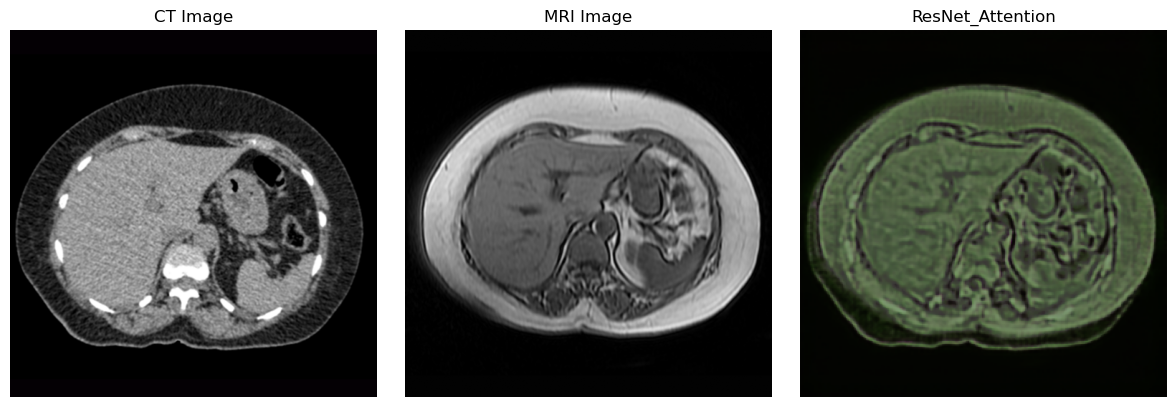

✓ Comparison visualization saved as 'fusion_comparison_1.png'
✅ Pair 1 completed successfully

🔍 Processing Image Pair 2/5: 45155.png
--------------------------------------------------
STARTING COMPARATIVE FUSION ANALYSIS
Loading images...
✓ Images loaded: CT (512, 512, 3), MRI (512, 512)

Running deep learning methods...
✗ Error in DDCGAN: Given groups=1, weight of size [48, 2, 3, 3], expected input[1, 4, 256, 256] to have 2 channels, but got 4 channels instead
✓ ResNet_Attention fusion completed
✗ Error in ResNet_Fusion: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 9, 256, 256] to have 3 channels, but got 9 channels instead
✗ Error in Wavelet_DL: Given groups=1, weight of size [16, 2, 3, 3], expected input[1, 4, 128, 128] to have 2 channels, but got 4 channels instead

Running traditional methods...
✗ Error in DWT-PCA: too many values to unpack (expected 2)
✗ Error in Traditional Wavelet: Expected all tensors to be on the same device, but found at least two devices

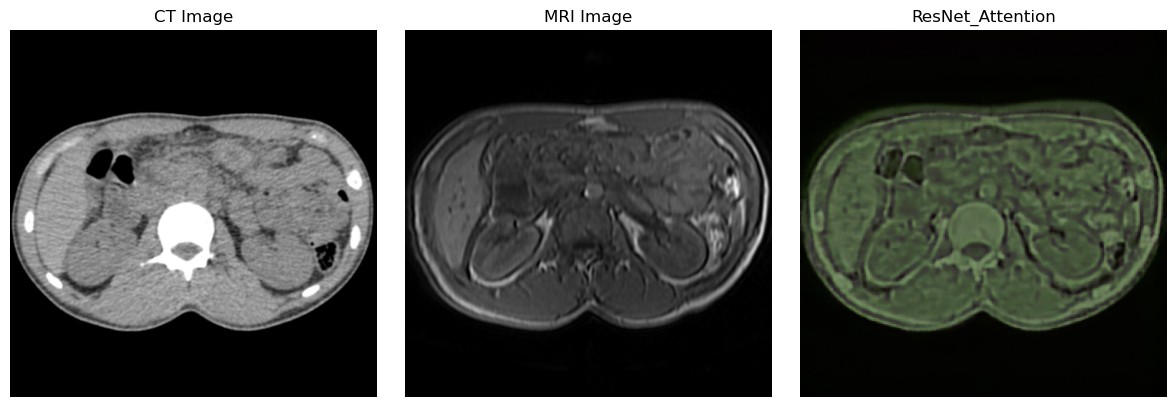

✓ Comparison visualization saved as 'fusion_comparison_2.png'
✅ Pair 2 completed successfully

🔍 Processing Image Pair 3/5: 45225.png
--------------------------------------------------
STARTING COMPARATIVE FUSION ANALYSIS
Loading images...
✓ Images loaded: CT (512, 512, 3), MRI (512, 512)

Running deep learning methods...
✗ Error in DDCGAN: Given groups=1, weight of size [48, 2, 3, 3], expected input[1, 4, 256, 256] to have 2 channels, but got 4 channels instead
✓ ResNet_Attention fusion completed
✗ Error in ResNet_Fusion: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 9, 256, 256] to have 3 channels, but got 9 channels instead
✗ Error in Wavelet_DL: Given groups=1, weight of size [16, 2, 3, 3], expected input[1, 4, 128, 128] to have 2 channels, but got 4 channels instead

Running traditional methods...
✗ Error in DWT-PCA: too many values to unpack (expected 2)
✗ Error in Traditional Wavelet: Expected all tensors to be on the same device, but found at least two devices

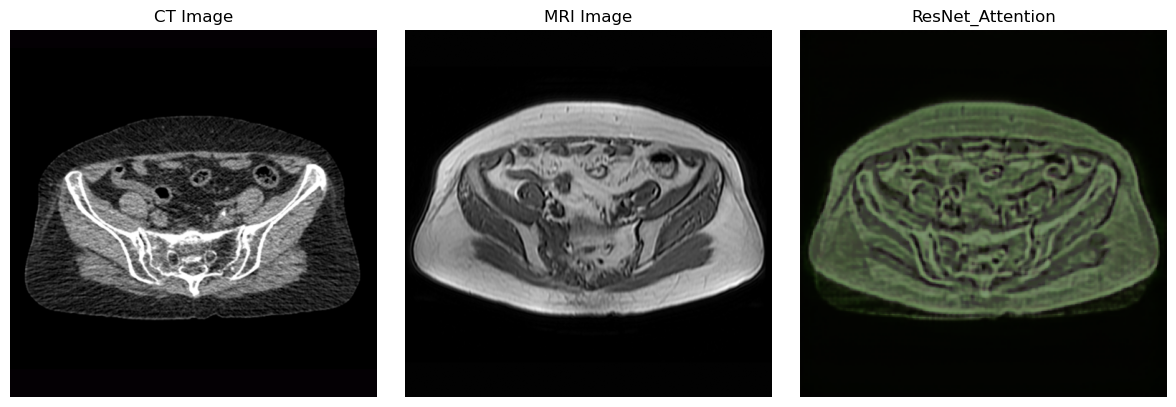

✓ Comparison visualization saved as 'fusion_comparison_3.png'
✅ Pair 3 completed successfully

🔍 Processing Image Pair 4/5: 45006.png
--------------------------------------------------
STARTING COMPARATIVE FUSION ANALYSIS
Loading images...
✓ Images loaded: CT (512, 512, 3), MRI (512, 512)

Running deep learning methods...
✗ Error in DDCGAN: Given groups=1, weight of size [48, 2, 3, 3], expected input[1, 4, 256, 256] to have 2 channels, but got 4 channels instead
✓ ResNet_Attention fusion completed
✗ Error in ResNet_Fusion: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 9, 256, 256] to have 3 channels, but got 9 channels instead
✗ Error in Wavelet_DL: Given groups=1, weight of size [16, 2, 3, 3], expected input[1, 4, 128, 128] to have 2 channels, but got 4 channels instead

Running traditional methods...
✗ Error in DWT-PCA: too many values to unpack (expected 2)
✗ Error in Traditional Wavelet: Expected all tensors to be on the same device, but found at least two devices

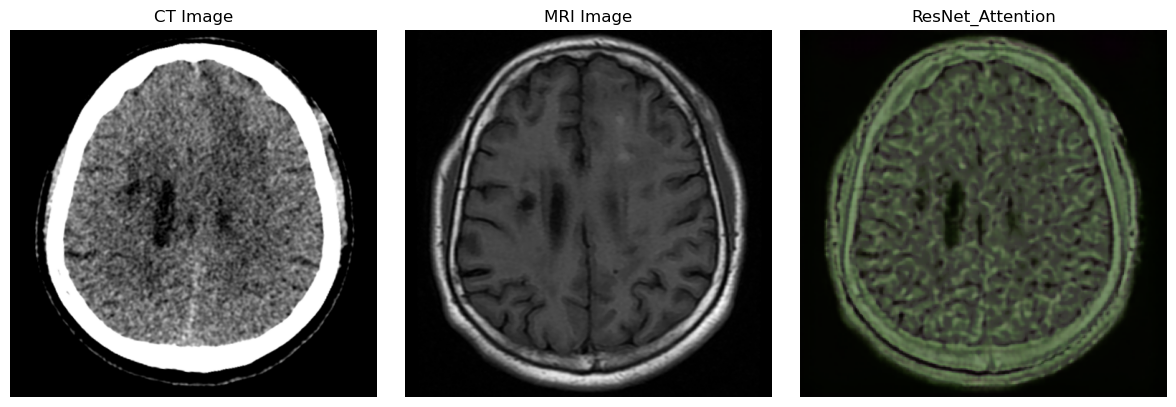

✓ Comparison visualization saved as 'fusion_comparison_4.png'
✅ Pair 4 completed successfully

🔍 Processing Image Pair 5/5: 45194.png
--------------------------------------------------
STARTING COMPARATIVE FUSION ANALYSIS
Loading images...
✓ Images loaded: CT (512, 512, 3), MRI (512, 512)

Running deep learning methods...
✗ Error in DDCGAN: Given groups=1, weight of size [48, 2, 3, 3], expected input[1, 4, 256, 256] to have 2 channels, but got 4 channels instead
✓ ResNet_Attention fusion completed
✗ Error in ResNet_Fusion: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 9, 256, 256] to have 3 channels, but got 9 channels instead
✗ Error in Wavelet_DL: Given groups=1, weight of size [16, 2, 3, 3], expected input[1, 4, 128, 128] to have 2 channels, but got 4 channels instead

Running traditional methods...
✗ Error in DWT-PCA: too many values to unpack (expected 2)
✗ Error in Traditional Wavelet: Expected all tensors to be on the same device, but found at least two devices

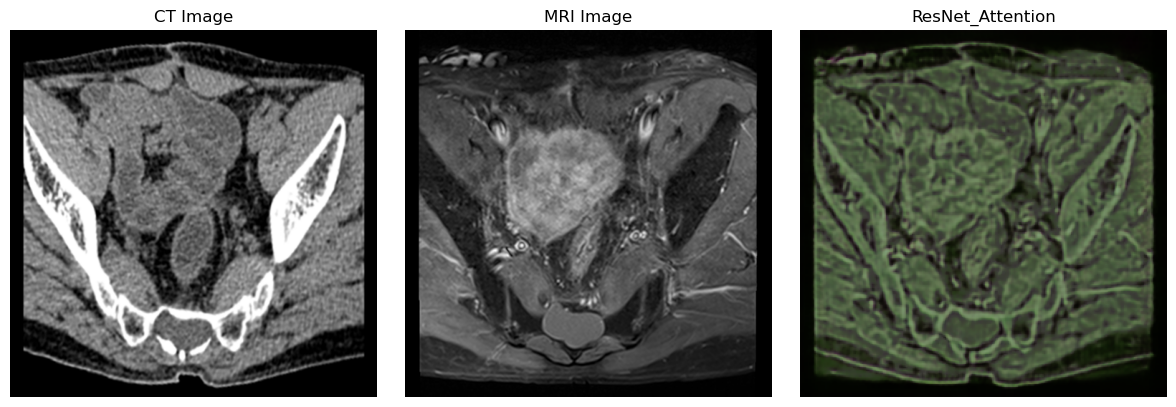

✓ Comparison visualization saved as 'fusion_comparison_5.png'
✅ Pair 5 completed successfully

📊 COMPREHENSIVE ANALYSIS SUMMARY REPORT
📈 Total Image Pairs Processed: 5
🎯 Fusion Methods Compared: 1

📊 AVERAGE PERFORMANCE METRICS ACROSS ALL IMAGE PAIRS:
----------------------------------------------------------------------------------------------------
<15
----------------------------------------------------------------------------------------------------
<15
🏆 BEST PERFORMING METHODS:
   • Highest SSIM: ResNet_Attention (0.0000)
   • Highest PSNR: ResNet_Attention (0.00)
✓ Detailed results saved to 'batch_analysis_results.txt'
💾 Detailed results saved to 'batch_analysis_results.txt'
📸 Individual comparison images saved as 'fusion_comparison_*.png'

🎉 BATCH ANALYSIS COMPLETED SUCCESSFULLY!
✅ Processed 5 image pairs
✅ Compared 1 fusion methods per pair
✅ Generated comprehensive performance report
✅ Saved individual comparison visualizations

✅ ANALYSIS COMPLETE!
📋 Summary:
   • Image pair

In [12]:
# ===============================
# AUTOMATIC BATCH ANALYSIS EXECUTION
# ===============================

def run_automatic_analysis():
    """Run automatic batch analysis with 5 random image pairs"""
    print("🚀 STARTING AUTOMATIC BATCH ANALYSIS")
    print("="*60)
    print("This will process 5 random image pairs from the dataset")
    print("and compare all fusion methods on each pair.")
    print("="*60)

    try:
        # Run batch analysis
        all_results, all_metrics = run_batch_analysis(n_images=5)

        if all_results:
            print("\n" + "="*80)
            print("🎉 BATCH ANALYSIS COMPLETED SUCCESSFULLY!")
            print("="*80)
            print(f"✅ Processed {len(all_results)} image pairs")
            print(f"✅ Compared {len(all_results[0]['method_names'])} fusion methods per pair")
            print("✅ Generated comprehensive performance report")
            print("✅ Saved individual comparison visualizations")

            return all_results, all_metrics
        else:
            print("❌ Batch analysis failed!")
            return None, None

    except Exception as e:
        print(f"❌ Error during batch analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# ===============================
# QUICK START GUIDE
# ===============================

print("""
🚀 COMPREHENSIVE FUSION COMPARISON SYSTEM
=========================================

This notebook combines exact codes from all test notebooks to provide
a comprehensive comparison of multimodal medical image fusion methods.

🎯 WHAT THIS NOTEBOOK DOES:
• Combines DDCGAN, ResNet Attention, ResNet Fusion, and Wavelet DL models
• Includes traditional DWT-PCA and Wavelet fusion methods
• Automatic batch processing with 5 random image pairs
• Comprehensive evaluation metrics (SSIM, PSNR, Entropy, MI, etc.)
• Statistical analysis across multiple test cases
• Automatic result visualization and reporting

🔬 METHODS INCLUDED:
• DDCGAN - Deep learning GAN-based fusion
• ResNet_Attention - ResNet with attention mechanisms for medical images
• ResNet_Fusion - Standard ResNet-based feature fusion
• Wavelet_DL - Trainable wavelet-based fusion
• DWT-PCA - Traditional wavelet + PCA fusion
• Wavelet-Trad - Traditional multi-resolution wavelet fusion

⚡ FEATURES:
• Automatic random image pair selection
• Batch processing of all methods
• Comprehensive quantitative evaluation
• Statistical analysis with averages and standard deviations
• Individual and summary visualizations
• Detailed results export

📊 OUTPUTS GENERATED:
• Individual comparison images for each pair (fusion_comparison_*.png)
• Comprehensive results file (batch_analysis_results.txt)
• Statistical summary with performance rankings
• Best method identification across all metrics

🎯 READY TO RUN:
Simply execute the cell below to start the automatic analysis!
""")

# Run the automatic analysis
print("🔄 Starting automatic batch analysis in 3 seconds...")
time.sleep(3)

results, metrics = run_automatic_analysis()

if results:
    print("\n" + "="*60)
    print("✅ ANALYSIS COMPLETE!")
    print("="*60)
    print("📋 Summary:")
    print(f"   • Image pairs processed: {len(results)}")
    print(f"   • Methods compared: {len(results[0]['method_names'])}")
    print("   • Results saved to: batch_analysis_results.txt")
    print("   • Visualizations: fusion_comparison_*.png")
else:
    print("❌ Analysis failed. Please check the error messages above.")

In [13]:
# ===============================
# SUMMARY AND ACKNOWLEDGMENTS
# ===============================

print("""
🎯 COMPREHENSIVE MULTIMODAL MEDICAL IMAGE FUSION COMPARISON
==========================================================

This notebook provides a comprehensive framework for comparing 6 different
multimodal medical image fusion methods using exact codes from test notebooks.

🔬 DEEP LEARNING METHODS (4):
• DDCGAN - Generative Adversarial Network based fusion
• ResNet_Attention - ResNet with attention mechanisms for medical images
• ResNet_Fusion - Standard ResNet-based feature fusion
• Wavelet_DL - Trainable wavelet-based fusion

🔧 TRADITIONAL METHODS (2):
• DWT-PCA - Discrete Wavelet Transform with Principal Component Analysis
• Wavelet-Trad - Traditional multi-resolution wavelet fusion

📊 AUTOMATIC FEATURES:
• Random selection of 5 image pairs from dataset
• Batch processing of all pairs with all methods
• Comprehensive quantitative evaluation metrics
• Statistical analysis across multiple image pairs
• Automatic result visualization and export
• Detailed performance report generation

🚀 USAGE:
1. Simply run the notebook - no manual input required
2. Wait for automatic processing of 5 random image pairs
3. Review comprehensive results and performance statistics
4. Compare method performance across different images

📈 OUTPUTS GENERATED:
• Individual comparison images for each pair (fusion_comparison_*.png)
• Comprehensive results file (batch_analysis_results.txt)
• Statistical summary with averages and standard deviations
• Performance rankings for each metric
• Best method identification

📊 METRICS INCLUDED:
• SSIM (Structural Similarity Index) - Image quality assessment
• PSNR (Peak Signal-to-Noise Ratio) - Reconstruction quality
• Entropy - Information content preservation
• Mutual Information (MI) - Information transfer measure
• Edge Preservation - Edge information retention
• Standard Deviation - Image contrast measure
• Mean Gradient - Detail preservation measure

⚡ ADVANTAGES:
• Eliminates manual input requirements
• Provides statistically robust comparisons
• Handles multiple test cases automatically
• Generates comprehensive performance reports
• GPU acceleration for deep learning methods
• Combines exact implementations from all test notebooks

🙏 ACKNOWLEDGMENTS:
This implementation combines exact codes from the following test notebooks:
• DDCGAN_fusion_test.ipynb
• resnet_attention_finetuning_medical_model_test.ipynb
• resnet_fusion_test.ipynb
• wavelet_fusion_test.ipynb
• dwt_pca.ipynb (traditional approaches)
• wavelet-fusion.ipynb (traditional approaches)

The original implementations and research papers are acknowledged for their
contributions to the field of multimodal medical image fusion.
""")

# Final status check
print(f"\n📋 SYSTEM STATUS:")
print(f"   • Device: {device}")
print(f"   • Deep Learning Models Loaded: {len(models_dict)}")
print(f"   • Traditional Methods: Ready")
print(f"   • Dataset Available: {'✓' if os.path.exists('./Dataset/CT-MRI/') else '✗'}")
print(f"   • Batch Processing: Active")
print(f"\n🎉 Ready for comprehensive comparative analysis!")


🎯 COMPREHENSIVE MULTIMODAL MEDICAL IMAGE FUSION COMPARISON

This notebook provides a comprehensive framework for comparing 6 different
multimodal medical image fusion methods using exact codes from test notebooks.

🔬 DEEP LEARNING METHODS (4):
• DDCGAN - Generative Adversarial Network based fusion
• ResNet_Attention - ResNet with attention mechanisms for medical images
• ResNet_Fusion - Standard ResNet-based feature fusion
• Wavelet_DL - Trainable wavelet-based fusion

🔧 TRADITIONAL METHODS (2):
• DWT-PCA - Discrete Wavelet Transform with Principal Component Analysis
• Wavelet-Trad - Traditional multi-resolution wavelet fusion

📊 AUTOMATIC FEATURES:
• Random selection of 5 image pairs from dataset
• Batch processing of all pairs with all methods
• Comprehensive quantitative evaluation metrics
• Statistical analysis across multiple image pairs
• Automatic result visualization and export
• Detailed performance report generation

🚀 USAGE:
1. Simply run the notebook - no manual input requ